### Project Description
* Customer Lifetime Value means a customer's purchase history from the beginning of its first purchase to the current date.
* This means the monetary value of a customer during its relation with the company.
* If we know the benefit that a customer brings to the company than it is easier to manage the relations.
* We will make CLTV Predicition by using BGNBD and Gamma-Gamma model
* Instead of calculate the current value of a custumer lifetime; we will predict the value for example 6 months or 1 year


#### Dataset
The dataset named online_retail_II includes sales information of an online retail company based on England between 2009-2011.

#### Data Description
InvoiceNo: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation.

StockCode: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product.

Description: Product (item) name. Nominal.

Quantity: The quantities of each product (item) per transaction. Numeric.

InvoiceDate: Invice date and time. Numeric. The day and time when a transaction was generated.

UnitPrice: Unit price. Numeric. Product price per unit in sterling (£).

CustomerID: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer.

Country: Country name. Nominal. The name of the country where a customer resides.


## DATA PREPARATION

In [2]:
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
!pip install lifetimes
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.float_format", lambda x: "%.2f" % x)

     |████████████████████████████████| 584 kB 889 kB/s eta 0:00:01


In [12]:
!pip install openpyxl

     |████████████████████████████████| 243 kB 890 kB/s eta 0:00:01
  Created wheel for et-xmlfile: filename=et_xmlfile-1.0.1-py3-none-any.whl size=8913 sha256=d3cbcbc2eb9ad115d3ec9c010e5ca6128ad0c7309036d1fd4dfe41b9b8bd0306
  Stored in directory: /root/.cache/pip/wheels/e2/bd/55/048b4fd505716c4c298f42ee02dffd9496bb6d212b266c7f31
Successfully built et-xmlfile


In [13]:
df_ = pd.read_excel("../input/uci-online-retail-ii-data-set/online_retail_II.xlsx", sheet_name="Year 2010-2011")
df=df_.copy()

In [15]:
df.shape

(541910, 8)

In [16]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.00,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.00,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom


In [14]:
df.info()
df.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      541910 non-null  object        
 1   StockCode    541910 non-null  object        
 2   Description  540456 non-null  object        
 3   Quantity     541910 non-null  int64         
 4   InvoiceDate  541910 non-null  datetime64[ns]
 5   Price        541910 non-null  float64       
 6   Customer ID  406830 non-null  float64       
 7   Country      541910 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


,count,mean,std,min,25%,50%,75%,max
Quantity,541910.00,9.55,218.08,-80995.00,1.00,3.00,10.00,80995.00
Price,541910.00,4.61,96.76,-11062.06,1.25,2.08,4.13,38970.00
Customer ID,406830.00,15287.68,1713.60,12346.00,13953.00,15152.00,16791.00,18287.00


In [17]:
# Let's take only United Kingdom for calculation to be fast and take out the returned products from the data
df.dropna(inplace=True)
df = df[~(df["Invoice"].str.contains("C", na=False))]
df = df[df["Quantity"] > 0]
df = df[df["Country"] == "United Kingdom"]
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,354345.00,12.05,190.43,1.00,2.00,4.00,12.00,80995.00
Price,354345.00,2.96,17.86,0.00,1.25,1.95,3.75,8142.75
Customer ID,354345.00,15552.44,1594.55,12346.00,14194.00,15522.00,16931.00,18287.00


In [19]:
# to define and outlier threshold:
def outlier_thresholds(dataframe, variable):
    Q1=dataframe[variable].quantile(0.01)
    Q3=dataframe[variable].quantile(0.99)
    interquartile_range= Q3 - Q1
    up_limit = Q3 + 1.5 * interquartile_range
    low_limit = Q1 - 1.5 * interquartile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    # dataframe.loc[(dataframe[variable]< low_limit), variable]=low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable]=up_limit

In [21]:
replace_with_thresholds(df, "Quantity")
replace_with_thresholds(df, "Price")
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,354345.00,10.68,22.08,1.00,2.00,4.00,12.00,248.50
Price,354345.00,2.82,2.92,0.00,1.25,1.95,3.75,31.56
Customer ID,354345.00,15552.44,1594.55,12346.00,14194.00,15522.00,16931.00,18287.00


In [23]:
df["TotalPrice"] = df["Price"] * df["Quantity"]
df["InvoiceDate"].max()
today_date = dt.datetime(2011, 12, 11)
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.00,2010-12-01 08:26:00,2.55,17850.00,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6.00,2010-12-01 08:26:00,3.39,17850.00,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.00,2010-12-01 08:26:00,2.75,17850.00,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.00,2010-12-01 08:26:00,3.39,17850.00,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.00,2010-12-01 08:26:00,3.39,17850.00,United Kingdom,20.34


## RFM TABLE

In [24]:
rfm = df.groupby('Customer ID').agg({'InvoiceDate': [lambda date: (date.max() -date.min()).days,
                                                     lambda date: (today_date - date.min()).days],
                                     'Invoice': lambda num: num.nunique(),
                                     'TotalPrice': lambda TotalPrice: TotalPrice.sum()})

rfm.columns = rfm.columns.droplevel(0)
rfm.columns = ['recency_cltv_p', 'T', 'frequency', 'monetary']
rfm.head()
# requency gives the number of unique purhase from the company which we can measure with the unique number of invoice
# monetary is the total revenue that the company makes out of each customer
# T is the tenure measuring the time between the first purchase and today's date
# recency is the time between first and last purchase of a customer

,recency_cltv_p,T,frequency,monetary
Customer ID,,,,
12346.00,0,326,1,258.44
12747.00,366,370,11,4196.01
12748.00,372,374,210,32303.91
12749.00,209,214,5,4072.44
12820.00,323,327,4,942.34


In [25]:
rfm["monetary"] = rfm["monetary"] / rfm["frequency"]
rfm.rename(columns={"monetary": "monetary_avg"}, inplace=True)

rfm["recency_weekly_p"] = rfm["recency_cltv_p"] / 7
rfm["T_weekly"] = rfm["T"] / 7

rfm = rfm[rfm["monetary_avg"] > 0] 
rfm = rfm[(rfm['frequency'] > 1)] # at least one purchase should be made
rfm["frequency"] = rfm["frequency"].astype(int)

rfm.head()

,recency_cltv_p,T,frequency,monetary_avg,recency_weekly_p,T_weekly
Customer ID,,,,,,
12747.00,366,370,11,381.46,52.29,52.86
12748.00,372,374,210,153.83,53.14,53.43
12749.00,209,214,5,814.49,29.86,30.57
12820.00,323,327,4,235.59,46.14,46.71
12822.00,16,88,2,474.44,2.29,12.57


## BG/NBD MODEL

In [26]:
bgf = BetaGeoFitter(penalizer_coef=0.001)

bgf.fit(rfm['frequency'],
        rfm['recency_weekly_p'],
        rfm['T_weekly'])

<lifetimes.BetaGeoFitter: fitted with 2570 subjects, a: 0.12, alpha: 11.66, b: 2.51, r: 2.21>

Who are the top 10 customers that we expect to spend the most according to the model in 1 week?

In [27]:
bgf.predict(1,
            rfm['frequency'],
            rfm['recency_weekly_p'],
            rfm['T_weekly']).sort_values(ascending=False).head(10)

Customer ID
12748.00   3.25
17841.00   1.93
13089.00   1.53
14606.00   1.46
15311.00   1.43
12971.00   1.35
13408.00   0.98
18102.00   0.97
13798.00   0.91
14527.00   0.88
dtype: float64

In [28]:
rfm["expected_number_of_purchases"] = bgf.predict(1,
                                                  rfm['frequency'],
                                                  rfm['recency_weekly_p'],
                                                  rfm['T_weekly'])

rfm.head()


,recency_cltv_p,T,frequency,monetary_avg,recency_weekly_p,T_weekly,expected_number_of_purchases
Customer ID,,,,,,,
12747.00,366,370,11,381.46,52.29,52.86,0.20
12748.00,372,374,210,153.83,53.14,53.43,3.25
12749.00,209,214,5,814.49,29.86,30.57,0.17
12820.00,323,327,4,235.59,46.14,46.71,0.10
12822.00,16,88,2,474.44,2.29,12.57,0.13


Who are the top 10 customers that we expect to spend the most according to the model in 1 month?

In [29]:
bgf.predict(4,
            rfm['frequency'],
            rfm['recency_weekly_p'],
            rfm['T_weekly']).sort_values(ascending=False).head(10)

Customer ID
12748.00   12.98
17841.00    7.71
13089.00    6.11
14606.00    5.82
15311.00    5.70
12971.00    5.39
13408.00    3.92
18102.00    3.85
13798.00    3.62
14527.00    3.52
dtype: float64

In [30]:
rfm["expected_number_of_purchases"] = bgf.predict(4,
                                                  rfm['frequency'],
                                                  rfm['recency_weekly_p'],
                                                  rfm['T_weekly'])

rfm.sort_values("expected_number_of_purchases", ascending=False).head(20)

,recency_cltv_p,T,frequency,monetary_avg,recency_weekly_p,T_weekly,expected_number_of_purchases
Customer ID,,,,,,,
12748.00,372,374,210,153.83,53.14,53.43,12.98
17841.00,371,374,124,328.82,53.00,53.43,7.71
13089.00,366,370,97,605.19,52.29,52.86,6.11
14606.00,372,374,93,129.96,53.14,53.43,5.82
15311.00,373,374,91,667.60,53.29,53.43,5.70
12971.00,368,373,86,127.05,52.57,53.29,5.39
13408.00,371,374,62,453.28,53.00,53.43,3.92
18102.00,366,368,60,3584.89,52.29,52.57,3.85
13798.00,370,373,57,650.51,52.86,53.29,3.62


What is the expected number of sales for the company in 1 month?

In [31]:
bgf.predict(4,
            rfm['frequency'],
            rfm['recency_weekly_p'],
            rfm['T_weekly']).sum()

1597.2732671032315

What is the expected number of sales for the company in 3 month?

In [32]:
bgf.predict(4 * 3,
            rfm['frequency'],
            rfm['recency_weekly_p'],
            rfm['T_weekly']).sum()

4738.99930983477

In [ ]:
Evaluation of Prediction Results

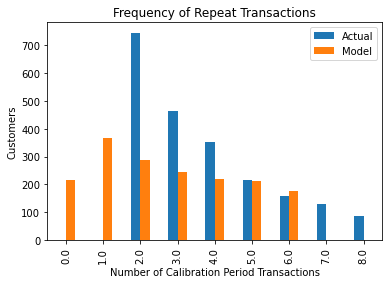

In [33]:
plot_period_transactions(bgf)
plt.show()

## GAMMA-GAMMA MODEL

In [35]:
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(rfm['frequency'], rfm['monetary_avg'])

ggf.conditional_expected_average_profit(rfm['frequency'],
                                        rfm['monetary_avg']).head(10)

rfm["expected_average_profit"] = ggf.conditional_expected_average_profit(rfm['frequency'],
                                                                         rfm['monetary_avg'])

rfm.sort_values("expected_average_profit", ascending=False).head(10)

,recency_cltv_p,T,frequency,monetary_avg,recency_weekly_p,T_weekly,expected_number_of_purchases,expected_average_profit
Customer ID,,,,,,,,
14088.00,312,323,13,3859.60,44.57,46.14,1.04,3911.32
18102.00,366,368,60,3584.89,52.29,52.57,3.85,3595.19
14096.00,97,102,17,3159.08,13.86,14.57,2.87,3191.39
17511.00,370,374,31,2921.95,52.86,53.43,2.02,2938.27
15749.00,97,333,3,2521.45,13.86,47.57,0.11,2675.12
17450.00,359,368,46,2629.53,51.29,52.57,2.97,2639.42
13081.00,359,372,11,2575.62,51.29,53.14,0.80,2616.62
16984.00,41,131,2,2240.68,5.86,18.71,0.41,2452.12
16000.00,0,3,3,2055.79,0.00,0.43,1.64,2181.32


### 1 Month CLTV Prediction with BG-NBD & GG Model

In [39]:
cltv_1 = ggf.customer_lifetime_value(bgf,
                                   rfm['frequency'],
                                   rfm['recency_weekly_p'],
                                   rfm['T_weekly'],
                                   rfm['monetary_avg'],
                                   time=1,  # 1 month
                                   freq="W",  # Tenure frequency information-weekly.
                                   discount_rate=0.01)

cltv_1.head()

Customer ID
12747.00    336.78
12748.00   2148.38
12749.00    604.07
12820.00    110.12
12822.00    286.92
Name: clv, dtype: float64

In [40]:
cltv_1 = cltv_1.reset_index()
cltv_1.rename(columns={"clv":"clv_1"}, inplace=True)
cltv_1.head()

,Customer ID,clv_1
0,12747.00,336.78
1,12748.00,2148.38
2,12749.00,604.07
3,12820.00,110.12
4,12822.00,286.92


### 6 Month CLTV Prediction with BG-NBD & GG Model

In [41]:
cltv_6 = ggf.customer_lifetime_value(bgf,
                                   rfm['frequency'],
                                   rfm['recency_weekly_p'],
                                   rfm['T_weekly'],
                                   rfm['monetary_avg'],
                                   time=6,  # 6 month
                                   freq="W",  # Tenure frequency information-weekly.
                                   discount_rate=0.01)

cltv_6 = cltv_6.reset_index()
cltv_6.rename(columns={"clv":"clv_6"}, inplace=True)
cltv_6.head()

,Customer ID,clv_6
0,12747.00,1937.05
1,12748.00,12365.80
2,12749.00,3446.01
3,12820.00,631.94
4,12822.00,1612.10


### 12 Month CLTV Prediction with BG-NBD & GG Model

In [42]:
cltv_12 = ggf.customer_lifetime_value(bgf,
                                   rfm['frequency'],
                                   rfm['recency_weekly_p'],
                                   rfm['T_weekly'],
                                   rfm['monetary_avg'],
                                   time=12,  # 12 aylık
                                   freq="W",  # T'nin frekans bilgisi.
                                   discount_rate=0.01)

cltv_12 = cltv_12.reset_index()
cltv_12.rename(columns={"clv":"clv_12"}, inplace=True)
cltv_12.head()

,Customer ID,clv_12
0,12747.00,3698.38
1,12748.00,23624.00
2,12749.00,6538.83
3,12820.00,1204.33
4,12822.00,3029.79


### Merge Tables

In [43]:
cltv_1_6 = cltv_1.merge(cltv_6, on="Customer ID", how="left")
cltv_1_6.head()
cltv_final = cltv_1_6.merge(cltv_12, on="Customer ID", how= "left")
cltv_final.head()

rfm_cltv_final = rfm.merge(cltv_final, on="Customer ID", how= "left")
rfm_cltv_final.head()

rfm_cltv_final.head(15)

,Customer ID,recency_cltv_p,T,frequency,monetary_avg,recency_weekly_p,T_weekly,expected_number_of_purchases,expected_average_profit,clv_1,clv_6,clv_12
0,12747.00,366,370,11,381.46,52.29,52.86,0.81,387.82,336.78,1937.05,3698.38
1,12748.00,372,374,210,153.83,53.14,53.43,12.98,153.97,2148.38,12365.80,23624.00
2,12749.00,209,214,5,814.49,29.86,30.57,0.67,844.09,604.07,3446.01,6538.83
3,12820.00,323,327,4,235.59,46.14,46.71,0.41,247.08,110.12,631.94,1204.33
4,12822.00,16,88,2,474.44,2.29,12.57,0.51,520.83,286.92,1612.10,3029.79
5,12823.00,221,297,5,351.90,31.57,42.43,0.49,365.13,191.12,1095.51,2085.99
6,12826.00,362,366,7,210.67,51.71,52.29,0.57,216.50,131.67,757.01,1444.88
7,12827.00,38,45,3,143.38,5.43,6.43,1.10,153.37,181.13,1009.14,1888.16
8,12828.00,127,131,6,169.78,18.14,18.71,1.05,175.41,198.70,1125.11,2124.47
9,12829.00,23,361,2,138.11,3.29,51.57,0.02,153.07,2.81,16.11,30.72


#### Any difference between 1 month exp. cltv and 12 exp. cltv on customer basis? 

In [44]:
rfm_cltv_final[["Customer ID", "clv_1"]].sort_values(by="clv_1", ascending=False).head(10)

,Customer ID,clv_1
2486,18102.00,14884.97
589,14096.00,9855.88
2184,17450.00,8434.76
2213,17511.00,6394.32
1804,16684.00,4361.05
587,14088.00,4355.49
406,13694.00,4354.47
1173,15311.00,4098.87
133,13089.00,3984.05
1485,16000.00,3843.98


In [45]:
rfm_cltv_final[["Customer ID", "clv_12"]].sort_values(by="clv_12", ascending=False).head(10)

,Customer ID,clv_12
2486,18102.00,163591.13
589,14096.00,104900.44
2184,17450.00,92694.27
2213,17511.00,70285.65
1804,16684.00,47890.36
406,13694.00,47871.90
587,14088.00,47688.86
1173,15311.00,45067.81
133,13089.00,43795.47
1057,15061.00,40348.82


From the top 10 customers, only 2 of them have a slight order change comparing 1 and 12 month cltv prediciton and the last customer has changed from 1 month to 12 month in the top 10 order.

### Segmentation

In [ ]:
# Let us group the customers according to their 6 months cltv predictions and select the top 20%.

In [46]:
pd.qcut(rfm_cltv_final["clv_6"], 3, labels=["C", "B", "A"]).head()

rfm_cltv_final["clv_6_segment"]=pd.qcut(rfm_cltv_final["clv_6"], 3, labels=["C", "B", "A"])
rfm_cltv_final.head()
rfm_cltv_final.sort_values("clv_6", ascending=False).head(10)

,Customer ID,recency_cltv_p,T,frequency,monetary_avg,recency_weekly_p,T_weekly,expected_number_of_purchases,expected_average_profit,clv_1,clv_6,clv_12,clv_6_segment
2486,18102.00,366,368,60,3584.89,52.29,52.57,3.85,3595.19,14884.97,85651.01,163591.13,A
589,14096.00,97,102,17,3159.08,13.86,14.57,2.87,3191.39,9855.88,55650.65,104900.44,A
2184,17450.00,359,368,46,2629.53,51.29,52.57,2.97,2639.42,8434.76,48533.31,92694.27,A
2213,17511.00,370,374,31,2921.95,52.86,53.43,2.02,2938.27,6394.32,36797.01,70285.65,A
1804,16684.00,353,359,28,2120.05,50.43,51.29,1.90,2133.20,4361.05,25083.03,47890.36,A
406,13694.00,369,374,50,1267.36,52.71,53.43,3.18,1271.79,4354.47,25060.71,47871.90,A
587,14088.00,312,323,13,3859.60,44.57,46.14,1.04,3911.32,4355.49,25010.06,47688.86,A
1173,15311.00,373,374,91,667.60,53.29,53.43,5.70,668.89,4098.87,23591.39,45067.81,A
133,13089.00,366,370,97,605.19,52.29,52.86,6.11,606.29,3984.05,22927.69,43795.47,A
1057,15061.00,368,373,48,1108.31,52.57,53.29,3.07,1112.35,3670.42,21123.08,40348.82,A


In [47]:
# total customer
rfm_cltv_final.shape[0]

2570

In [48]:
# top 20% of customers:
2570*0.20

514.0

In [65]:
rfm_cltv_final_top = rfm_cltv_final.nlargest(514,columns="clv_6")
rfm_cltv_final_top.head(10)

,Customer ID,recency_cltv_p,T,frequency,monetary_avg,recency_weekly_p,T_weekly,expected_number_of_purchases,expected_average_profit,clv_1,clv_6,clv_12,clv_6_segment,Top_Flag
2486,18102.00,366,368,60,3584.89,52.29,52.57,3.85,3595.19,14884.97,85651.01,163591.13,A,top_flag_0
589,14096.00,97,102,17,3159.08,13.86,14.57,2.87,3191.39,9855.88,55650.65,104900.44,A,top_flag_0
2184,17450.00,359,368,46,2629.53,51.29,52.57,2.97,2639.42,8434.76,48533.31,92694.27,A,top_flag_0
2213,17511.00,370,374,31,2921.95,52.86,53.43,2.02,2938.27,6394.32,36797.01,70285.65,A,top_flag_0
1804,16684.00,353,359,28,2120.05,50.43,51.29,1.90,2133.20,4361.05,25083.03,47890.36,A,top_flag_0
406,13694.00,369,374,50,1267.36,52.71,53.43,3.18,1271.79,4354.47,25060.71,47871.90,A,top_flag_1
587,14088.00,312,323,13,3859.60,44.57,46.14,1.04,3911.32,4355.49,25010.06,47688.86,A,top_flag_0
1173,15311.00,373,374,91,667.60,53.29,53.43,5.70,668.89,4098.87,23591.39,45067.81,A,top_flag_0
133,13089.00,366,370,97,605.19,52.29,52.86,6.11,606.29,3984.05,22927.69,43795.47,A,top_flag_1
1057,15061.00,368,373,48,1108.31,52.57,53.29,3.07,1112.35,3670.42,21123.08,40348.82,A,top_flag_0


In [70]:
rfm_cltv_final.groupby("clv_6_segment").agg({
                                            "monetary_avg": "mean",
                                             "recency_weekly_p": "mean",
                                            "T_weekly": "mean",
                                             "frequency": "mean",
                                             "expected_number_of_purchases": "mean",
                                             "expected_average_profit": "mean"}).head(10)



,monetary_avg,recency_weekly_p,T_weekly,frequency,expected_number_of_purchases,expected_average_profit
clv_6_segment,,,,,,
C,190.75,23.97,39.88,3.16,0.32,206.14
B,304.67,31.05,37.20,4.76,0.56,322.26
A,536.92,30.63,34.15,9.93,0.99,558.75


* We see that the A_segment customers have the highest profit brought to the company and by far have the highest frequency.
* Interestingly B_segment has a higher recency score than the others this brings to the conclusion that monetray values have higher impact on the cltv predictions.